# **Index No : 180677E**

## **EN2550 2021: Object Counting on a Convey Belt**

In this assignment, you will be counting and tracking the hexagonal nuts on a moving convey belt

**Let's first import required libraries**

In [69]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

%matplotlib inline

**Let's load and visualize the template image and the convey belt snapshot at a given time**

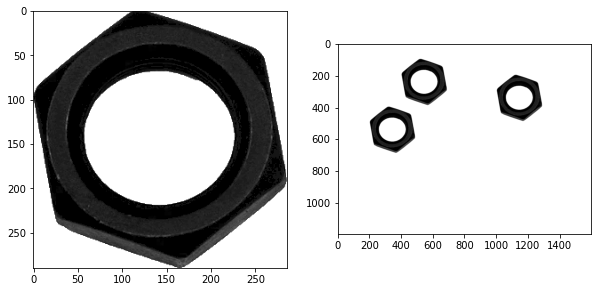

In [70]:
template_im = cv.imread(r'/template.png', cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(r'/belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

## **Part-I :**

Before going into the implementation, let's play with some functions

### **Otsu's thresholding**

Please read [thresholding](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) to get an idea about different types of thresholding and how to use them.(Please use cv.THRESH_BINARY_INV).

In [71]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

### **Morphological closing**

Carry out morphological closing to remove small holes inside the foreground. Use a 3 × 3 kernel. See [closing](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html) for a guide.

In [72]:
kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3)) 
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

Visualizing images after Otsu's thresholding and Morphological closing,

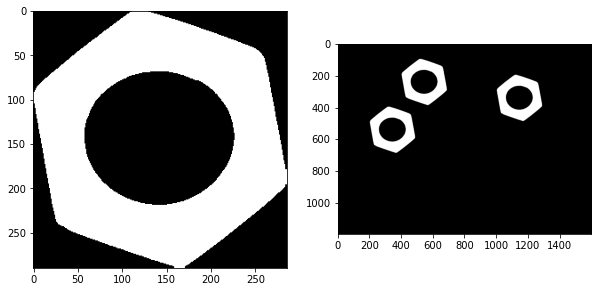

In [73]:
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

### **Connected component analysis**

Apply the connectedComponentsWithStats function ([see this](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga107a78bf7cd25dec05fb4dfc5c9e765f)).

In [74]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

* How many connected compoonets are detected in each image?

In template image, 2 connected components are detected which includes the hexagonal nut and the background connected component (usually black region). In belt image (snapshot over the conveyor belt at a time), total of 4 connected components are detected. Excluding background component, other 3 are related to hexagonal nuts. The number of connected components can be concluded from 'retval'.

* What are the statistics? Interpret these statistics.

'stats' is a matrix including statistical features of the image.Each row is a label (a single connected component) and each column is a new statistical feature describing that parituclar label. The features are,
leftmost x coordinate (inclusive start of bounding box in horizontal direction), topmost y coordinate (inclusive start of bounding box in vertical direction), horizontal/ vertical size of the bounding box and total area of connected component.


* What are the centroids?

'centroids' is a matrix of (x,y) pairs. Each label has a centroid whose location is described an (x,y) pair

### **Contour analysis**

Use findContours function to retrieve the extreme outer contours. ([see](https://docs.opencv.org/4.5.2/d4/d73/tutorial_py_contours_begin.html) for help and [see](https://docs.opencv.org/4.5.2/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) for information.)

Display these countours.

In [75]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

Visualizing contours of template image

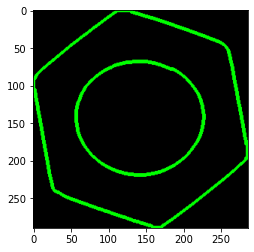

In [76]:
im_contours_t = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_t, contours_t, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

Visualizing contours of belt image

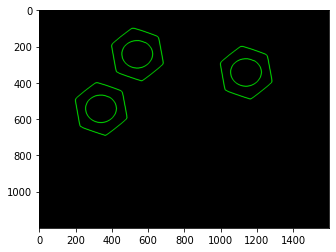

In [77]:
# Visualizing contours of belt image
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

### **Count the number of matching hexagonal nuts in belt.png**

Use the matchShapes function as shown in [examples](https://docs.opencv.org/4.5.2/d5/d45/tutorial_py_contours_more_functions.html) to match contours in the belt image with that in the template.

Get an idea about the value output by the cv.matchShapes when both the template and the reference image have the same shape. Understand the given code snippet.

In [78]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')   
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397151607
0.00010071698397928763
0.00010071698397484674


## **Part - II**

### **Frame tracking through image moments**

Use the cv.contourArea(), see [this](https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html) and calculate the the area of the contours_b[1]

In [79]:
cnt=contours_b[1]
ca = cv.contourArea(cnt)
print(ca)

20080.0


Use the cv.moments to extract the x and y coordinates of the centroid of contours_b[1]

In [80]:
M = cv.moments(cnt)
cx, cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])

Make a variable called count to represent the number of contours and set it to the value 1. Make an np array [cx, cy, ca, count] and name this as object_prev_frame

In [81]:
#count=number of contours
#considering index 1 contour of belt image
count=1
object_prev_frame = [cx, cy, ca, count]

Similarly, you can create the object_curr_frame(to describe the current values) and define the threshold delta_x to check whether the corresponding element of both the object_curr_frame and object_prev_frame are less than the delta_x. You can set delta_x as 15 or so. (Here the delta_x can be thought of as the movement of the cx from frame to frame)

In [82]:
#a movement along x direction
delta_x = 15

## **Part - III**

#### **1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)**

In [83]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 
    
    th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3)) 
    closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)


    return retval, labels, stats, centroids 

#### **2. Implement the function is_new, which checks the dissimilarity between 2 vectors. (Grading)**

In [84]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta. 
    vector i specifies which elements in b to compare with those in a. 
    """

    'Check whether the absolute different between all the elements of ith column of each array is greater than the ith delta value (See thee example in the next cell)'

    for r in range (a.shape[0]):
        if (abs(b[i]-a[r][i])<delta[0]):
          return False
    
    return True

In [85]:
# check is_new  expected answer False

a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

#print(is_new(a, b, delta, i))

assert is_new(a, b, delta, i) == False, " Check the function "

#### **3. If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of [cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame. (Grading)**

In [86]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    
    c=0
    for r in range (a.shape[0]):
        if (abs(b[i]-a[r][i])<delta[0]):
          if ((abs(b[i]-a[r][i]))<=(abs(b[i]-a[c][i]))):
            c=r
            index=a[c][-1]

    return index   

In [87]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

You can use following code snippet load and access each frame of a video

In [88]:
cap = cv.VideoCapture('/conveyor_with_rotation.mp4') # give the correct path here
frame_count=1
CONT=[] #list of lists containing all contours from all frames (sorted in frame order and within a frame as well)
FRAMES=[] #frames in order
DETAILS=[] #list of lists containing details of contours (cx, cy, ca, count) in frame order
total_nut_count=0

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
 
    grey = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    retval, labels, stats, centroids = get_indexed_image(grey)
    FRAMES.append(grey) #collecting BW frames
    
    belt = ((labels>=1)*255).astype('uint8') #clean BW image of belt

    frame_cont, frame_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #all external contours of this frame
    FRAME_CONT=[] #list of lists (hexagonal contours of this frame)
    for j,c in enumerate(frame_cont):
        if((cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))<0.01):
          FRAME_CONT.append(c)
    
    frame_nut_count=len(FRAME_CONT)
    
    a=[] #list of lists (external contour details for this frame)
    for count in range (frame_nut_count):
      contour=FRAME_CONT[count]
      ca = cv.contourArea(contour)
      M = cv.moments(contour)
      cx, cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])
      one_cont=[cx, cy, ca , count+1] #details for one contour of this frame
      
      a.append(one_cont)
      
    #sorting contours of this frame in their order in x direction
    a.sort(key=lambda a:a[0])
    
    #adding real index of each contour in current frame
    for i in range (len(a)):
      a[i][3]=i+1

    SORTED_FRAME_CONT=[] #list of lists (contours of one frame on position order)
    for i in range(frame_nut_count):
      index=int(a[i][3])-1
      SORTED_FRAME_CONT.append(FRAME_CONT[index])

    CONT.append(SORTED_FRAME_CONT)  #list of lists (hexagonal contours from all frames)
      
    a=np.array(a) #array of lists (contour details of this frame sorted in order of contours in x direction)
       
    if (frame_count!=1): #except first frame
      for i in range (frame_nut_count): 
        b=a[i]
        if is_new(a_prev, b, [delta_x], 0): #comparing each contour of current frame with all contours in previous frame
          total_nut_count+=1 
          a[i][3]=total_nut_count

        else:
          index=prev_index(a_prev, b, [delta_x], 0)
          a[i][3]=index
        
    else: #for the first frame
      total_nut_count+=frame_nut_count
    
    DETAILS.append(a) #list of arrays containing contour data
    frame_count+=1
    a_prev=a

    

Can't receive frame (stream end?). Exiting ...


In [89]:
OUTPUT=[] #sequence of output frames
font = cv.FONT_HERSHEY_SIMPLEX

for fr in range (len(FRAMES)):
  im_contours_belt = np.zeros((FRAMES[0].shape[0],FRAMES[0].shape[1],3), np.uint8)
  frame = cv.drawContours(im_contours_belt, CONT[fr], -1, (0,255,0), 3).astype('uint8')
  a = DETAILS[fr] #contour details for 'fr' th frame
  
  for j in range(a.shape[0]): #going through eaach contour in 'fr' th frame
    no=a[j][3]
    x=int(a[j][0])
    y=int(a[j][1])
    cv.putText(frame,str(int(no)),(x,y), font, 1,(0,255,0),2,cv.LINE_AA) #nut numbering
    cv.putText(frame,'Index No : 180677E' ,(50,100), font, 1,(0,255,0),2,cv.LINE_AA) #frame numbering
    cv.putText(frame,'Frame : ' + str(fr) ,(50,800), font, 1,(0,255,0),2,cv.LINE_AA) #frame numbering
    s='Object'+ ' ' + str(int(no))+ ':' + str(a[j][0]) + ' ' + str(a[j][1]) +' ' + str(a[j][2]) 
    end=  int(850+50*j)
    cv.putText(frame,s,(50,end), font, 1,(128,0,128),2,cv.LINE_AA) #contour details

  #cv2_imshow(frame)
  if cv.waitKey(1) == ord('q'):
    break

  OUTPUT.append(frame)




In [91]:
#writing frame sequence to a video
fourcc=cv.VideoWriter_fourcc(*"MP4V")
video=cv.VideoWriter('/180677E_en2550_a05.mp4',fourcc,30.0,(1920,1080), True)

for frame in OUTPUT:
  video.write(frame)

video.release()